In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import keras_tuner as kt
import joblib

In [9]:
# 1. Coleta de dados
symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-12-31'
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


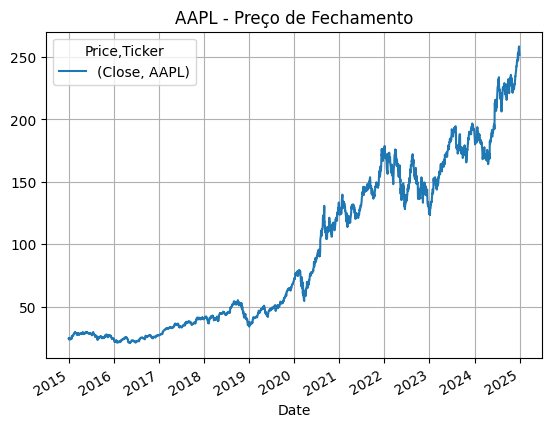

In [10]:
# Visualização inicial
df[['Date', 'Close']].set_index('Date').plot(title=f'{symbol} - Preço de Fechamento')
plt.grid(True)
plt.show()

In [11]:
# 2. Normalização
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print(scaled_data)

[[0.01531501]
 [0.01243695]
 [0.01244629]
 ...
 [1.        ]
 [0.98560779]
 [0.9713834 ]]


In [12]:
# 3. Função de criação de janelas
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X).reshape(-1, window_size, 1), np.array(y)

In [13]:
# 4. Avaliação do modelo com TimeSeriesSplit e métrica inversa à escala original
def evaluate_model(X, y, scaler):
    tscv = TimeSeriesSplit(n_splits=3)
    mae_list, rmse_list, mape_list = [], [], []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            LSTM(64),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

        predicted = model.predict(X_test)
        predicted = scaler.inverse_transform(predicted)
        real = scaler.inverse_transform(y_test.reshape(-1, 1))

        mae_list.append(mean_absolute_error(real, predicted))
        rmse_list.append(math.sqrt(mean_squared_error(real, predicted)))
        mape_list.append(np.mean(np.abs((real - predicted) / real)) * 100)

    return np.mean(mae_list), np.mean(rmse_list), np.mean(mape_list)

In [14]:
# 5. Teste com diferentes janelas para encontrar a melhor
print("\n=== AVALIAÇÃO POR TAMANHO DE JANELA ===\n")
best_window = None
best_mae = float('inf')

for window in [30, 60, 90]:
    X, y = create_sequences(scaled_data, window)
    mae, rmse, mape = evaluate_model(X, y, scaler)
    print(f"[Janela: {window}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

    if mae < best_mae:
        best_mae = mae
        best_window = window

print(f"\nMelhor janela encontrada: {best_window} dias (MAE = {best_mae:.2f})")


=== AVALIAÇÃO POR TAMANHO DE JANELA ===



c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
[Janela: 30] MAE: 4.98 | RMSE: 6.25 | MAPE: 3.75%


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[Janela: 60] MAE: 3.33 | RMSE: 4.25 | MAPE: 2.90%


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
[Janela: 90] MAE: 3.77 | RMSE: 4.84 | MAPE: 2.96%

Melhor janela encontrada: 60 dias (MAE = 3.33)


In [15]:
# 6. Keras Tuner com melhor janela
X, y = create_sequences(scaled_data, best_window)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', 32, 128, step=32), return_sequences=True, input_shape=(best_window, 1)))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.4, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', 32, 128, step=32)))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.4, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

print("\n=== KERAS TUNER ===\n")
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='unified_lstm'
)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
best_model = tuner.get_best_models(1)[0]


=== KERAS TUNER ===

Reloading Tuner from tuner_dir\unified_lstm\tuner0.json



c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\gtebi\OneDrive\Documentos\pos_fiap\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


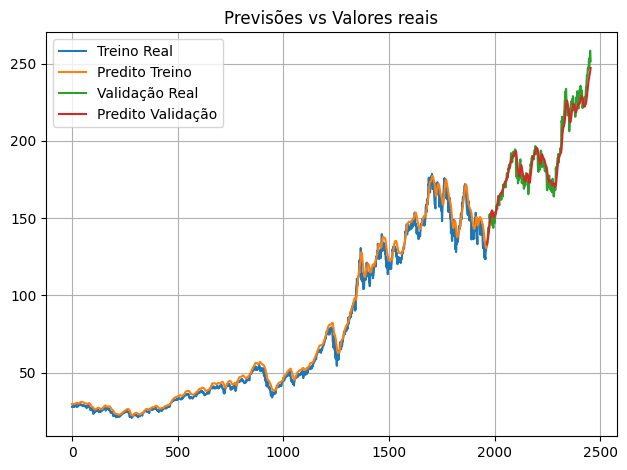


Métricas Finais:
MAE: 4.45 | RMSE: 5.68 | MAPE: 2.31%


In [16]:
# 7. Visualização das previsões
train_predictions = best_model.predict(X_train).flatten()
val_predictions = best_model.predict(X_val).flatten()

train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
y_train_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_real = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

plt.plot(range(len(y_train_real)), y_train_real, label='Treino Real')
plt.plot(range(len(train_predictions)), train_predictions, label='Predito Treino')
plt.plot(range(len(y_train_real), len(y_train_real) + len(y_val_real)), y_val_real, label='Validação Real')
plt.plot(range(len(train_predictions), len(train_predictions) + len(val_predictions)), val_predictions, label='Predito Validação')
plt.legend()
plt.title('Previsões vs Valores reais')
plt.grid(True)
plt.tight_layout()
plt.show()


# Avaliação das previsões com métricas
mae = mean_absolute_error(y_val_real, val_predictions)
rmse = math.sqrt(mean_squared_error(y_val_real, val_predictions))
mape = np.mean(np.abs((y_val_real - val_predictions) / y_val_real)) * 100

print(f"\nMétricas Finais:\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

In [11]:
# 8. Salvamento do modelo e scaler
best_model.save("./models/lstm_model.h5")
joblib.dump(scaler, "./models/scaler.pkl")
print("\nModelo e scaler salvos na pasta './models'")


Modelo e scaler salvos na pasta './models'
